# 06.1i: Black Hole Constellation

**Goal:** Analyze the spatial arrangement of the 13 primordial black holes.

From 06.1h, we found 13 degenerate clusters, all at radius r ≈ 0.3709. Are they:
- A tight cluster (all ~same point)?
- Distributed on a sphere?
- Arranged in a ring or arc?
- Clustered in one region?

This notebook:
1. Extracts one representative embedding per black hole
2. Computes full 13×13 pairwise distance matrix
3. Computes angular separations (cosine distances)
4. Visualizes constellation geometry
5. Compares to random distribution at same radius

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"

# The 13 black hole representative tokens (from 06.1h)
BLACK_HOLE_TOKENS = [
    80091,   # Rank 1: 814 tokens
    125,     # Rank 2: 704 tokens
    124,     # Rank 3: 306 tokens
    124350,  # Rank 4: 228 tokens
    123939,  # Rank 5: 11 tokens
    119349,  # Rank 6: 10 tokens
    126268,  # Rank 7: 6 tokens
    132383,  # Rank 8: 5 tokens
    135619,  # Rank 9: 4 tokens
    136831,  # Rank 10: 4 tokens
    180,     # Rank 11: 3 tokens
    126775,  # Rank 12: 3 tokens
    126816,  # Rank 13: 2 tokens
]

# Random seed for comparison
RANDOM_SEED = 42

## Imports

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Black Hole Embeddings

In [5]:
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']

# Extract the 13 black hole embeddings
black_holes = gamma[BLACK_HOLE_TOKENS]

n_holes = len(BLACK_HOLE_TOKENS)
d = black_holes.shape[1]

print(f"Loaded {n_holes} black hole embeddings:")
print(f"  Dimensions: {d:,}")
print(f"  Shape: {black_holes.shape}")

# Compute norms
norms = torch.norm(black_holes, dim=1)

print(f"\nNorms from origin:")
print(f"  Mean: {norms.mean().item():.12f}")
print(f"  Std: {norms.std().item():.12f}")
print(f"  Min: {norms.min().item():.12f}")
print(f"  Max: {norms.max().item():.12f}")
print(f"  Range: {(norms.max() - norms.min()).item():.12e}")

Loaded 13 black hole embeddings:
  Dimensions: 2,560
  Shape: torch.Size([13, 2560])

Norms from origin:
  Mean: 0.370916843414
  Std: 0.000000405355
  Min: 0.370915770531
  Max: 0.370917588472
  Range: 1.817941665649e-06


## Step 2: Pairwise Euclidean Distances

In [6]:
print("\n" + "="*70)
print("PAIRWISE EUCLIDEAN DISTANCES")
print("="*70)
print()

# Compute pairwise distances
distances = torch.cdist(black_holes, black_holes, p=2)

# Extract upper triangle (unique pairs)
upper_tri = torch.triu(distances, diagonal=1)
unique_distances = upper_tri[upper_tri > 0]

print(f"Pairwise distance statistics ({len(unique_distances)} pairs):")
print(f"  Mean: {unique_distances.mean().item():.12f}")
print(f"  Std: {unique_distances.std().item():.12f}")
print(f"  Min: {unique_distances.min().item():.12f}")
print(f"  Max: {unique_distances.max().item():.12f}")
print(f"  Range: {(unique_distances.max() - unique_distances.min()).item():.12f}")

print(f"\nFor context:")
print(f"  Mean radius: {norms.mean().item():.12f}")
print(f"  Max pairwise distance / mean radius: {(unique_distances.max() / norms.mean()).item():.4f}")


PAIRWISE EUCLIDEAN DISTANCES

Pairwise distance statistics (78 pairs):
  Mean: 0.000034002511
  Std: 0.000018963674
  Min: 0.000000007451
  Max: 0.000072617571
  Range: 0.000072610121

For context:
  Mean radius: 0.370916843414
  Max pairwise distance / mean radius: 0.0002


## Step 3: Pairwise Angular Separations

In [8]:
print("\n" + "="*70)
print("PAIRWISE ANGULAR SEPARATIONS")
print("="*70)
print()

# Normalize to unit sphere
black_holes_normed = black_holes / torch.norm(black_holes, dim=1, keepdim=True)

# Compute cosine similarities (dot products)
cosine_sims = black_holes_normed @ black_holes_normed.T

# Compute angular distances (in radians)
# θ = arccos(cos(θ))
# Clamp to [-1, 1] to avoid numerical issues
cosine_sims_clamped = torch.clamp(cosine_sims, -1.0, 1.0)
angular_distances = torch.acos(cosine_sims_clamped)

# Extract upper triangle (exclude diagonal)
# Don't filter by > 0 because angles can be arbitrarily close to zero
mask = torch.triu(torch.ones_like(angular_distances, dtype=bool), diagonal=1)
unique_angles = angular_distances[mask]

# Convert to degrees
unique_angles_deg = unique_angles * 180 / np.pi

print(f"Angular separation statistics ({len(unique_angles)} pairs):")
print(f"  Mean: {unique_angles.mean().item():.6f} rad = {unique_angles_deg.mean().item():.4f}°")
print(f"  Std: {unique_angles.std().item():.6f} rad = {unique_angles_deg.std().item():.4f}°")
print(f"  Min: {unique_angles.min().item():.6f} rad = {unique_angles_deg.min().item():.4f}°")
print(f"  Max: {unique_angles.max().item():.6f} rad = {unique_angles_deg.max().item():.4f}°")

print(f"\nFor a uniform distribution on a sphere:")
print(f"  Expected mean angle: ~π/2 rad = 90°")
print(f"  Expected max angle: ~π rad = 180°")


PAIRWISE ANGULAR SEPARATIONS

Angular separation statistics (78 pairs):
  Mean: 0.000000 rad = 0.0000°
  Std: 0.000000 rad = 0.0000°
  Min: 0.000000 rad = 0.0000°
  Max: 0.000000 rad = 0.0000°

For a uniform distribution on a sphere:
  Expected mean angle: ~π/2 rad = 90°
  Expected max angle: ~π rad = 180°


## Step 4: Distance Matrix Heatmaps


DISTANCE MATRIX VISUALIZATIONS



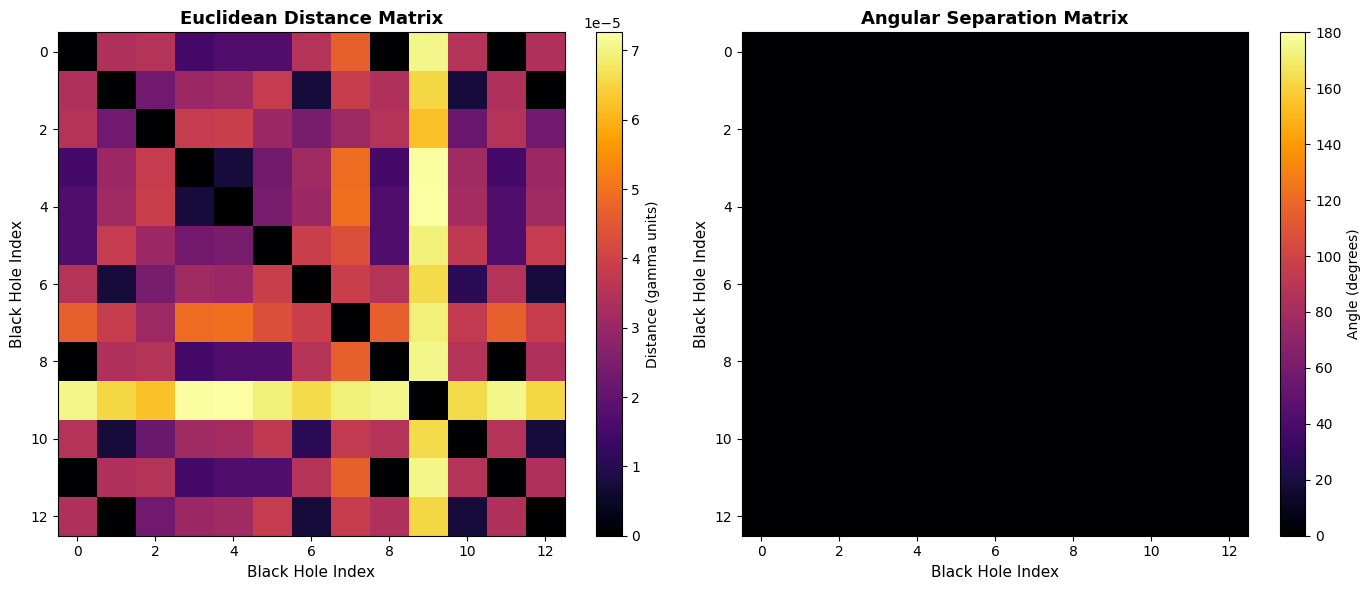

Heatmaps show pairwise distances between all 13 black holes.
Dark = close, bright = far apart.


In [9]:
print("\n" + "="*70)
print("DISTANCE MATRIX VISUALIZATIONS")
print("="*70)
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# Left: Euclidean distances
im1 = axes[0].imshow(distances.cpu().numpy(), cmap='inferno', aspect='auto')
axes[0].set_xlabel('Black Hole Index', fontsize=11)
axes[0].set_ylabel('Black Hole Index', fontsize=11)
axes[0].set_title('Euclidean Distance Matrix', fontsize=13, fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='Distance (gamma units)')

# Right: Angular distances (in degrees)
angular_distances_deg = angular_distances * 180 / np.pi
im2 = axes[1].imshow(angular_distances_deg.cpu().numpy(), cmap='inferno', aspect='auto', vmin=0, vmax=180)
axes[1].set_xlabel('Black Hole Index', fontsize=11)
axes[1].set_ylabel('Black Hole Index', fontsize=11)
axes[1].set_title('Angular Separation Matrix', fontsize=13, fontweight='bold')
plt.colorbar(im2, ax=axes[1], label='Angle (degrees)')

plt.tight_layout()
plt.show()

print("Heatmaps show pairwise distances between all 13 black holes.")
print("Dark = close, bright = far apart.")

## Step 5: Histogram of Separations


DISTRIBUTION OF SEPARATIONS



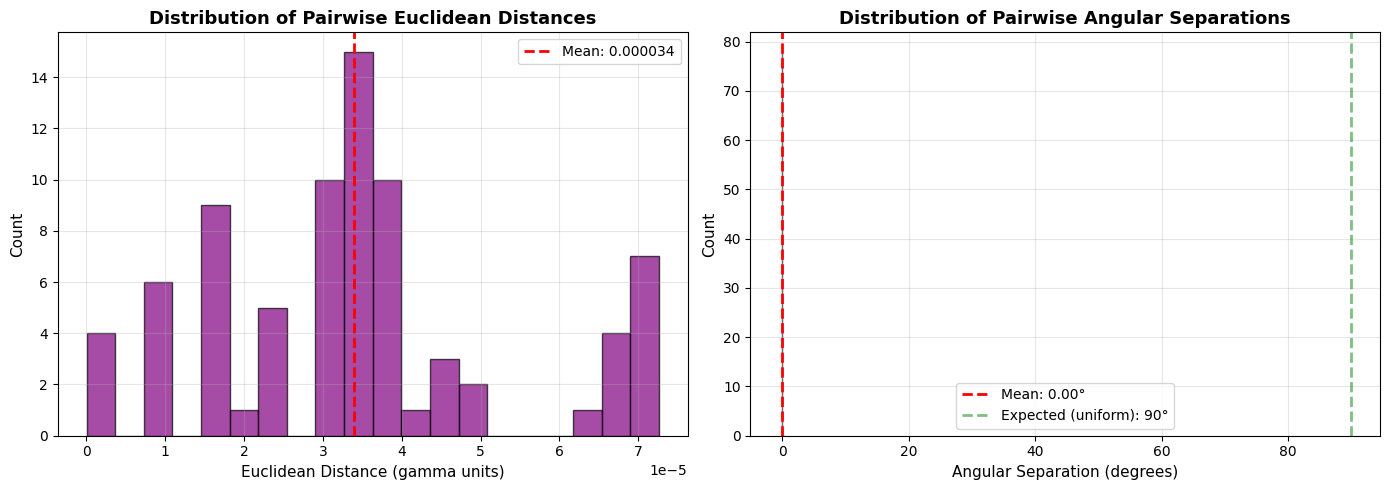

In [10]:
print("\n" + "="*70)
print("DISTRIBUTION OF SEPARATIONS")
print("="*70)
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Left: Euclidean distances
axes[0].hist(unique_distances.cpu().numpy(), bins=20, color='purple', alpha=0.7, edgecolor='black')
axes[0].axvline(unique_distances.mean().item(), color='red', linestyle='--', linewidth=2, label=f'Mean: {unique_distances.mean().item():.6f}')
axes[0].set_xlabel('Euclidean Distance (gamma units)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Distribution of Pairwise Euclidean Distances', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: Angular separations
axes[1].hist(unique_angles_deg.cpu().numpy(), bins=20, color='orange', alpha=0.7, edgecolor='black')
axes[1].axvline(unique_angles_deg.mean().item(), color='red', linestyle='--', linewidth=2, label=f'Mean: {unique_angles_deg.mean().item():.2f}°')
axes[1].axvline(90, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Expected (uniform): 90°')
axes[1].set_xlabel('Angular Separation (degrees)', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Distribution of Pairwise Angular Separations', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: PCA Projection (3D Visualization)


PCA PROJECTION

PCA explained variance:
  PC1: 48.13%
  PC2: 28.97%
  PC3: 14.97%
  Total: 92.07%



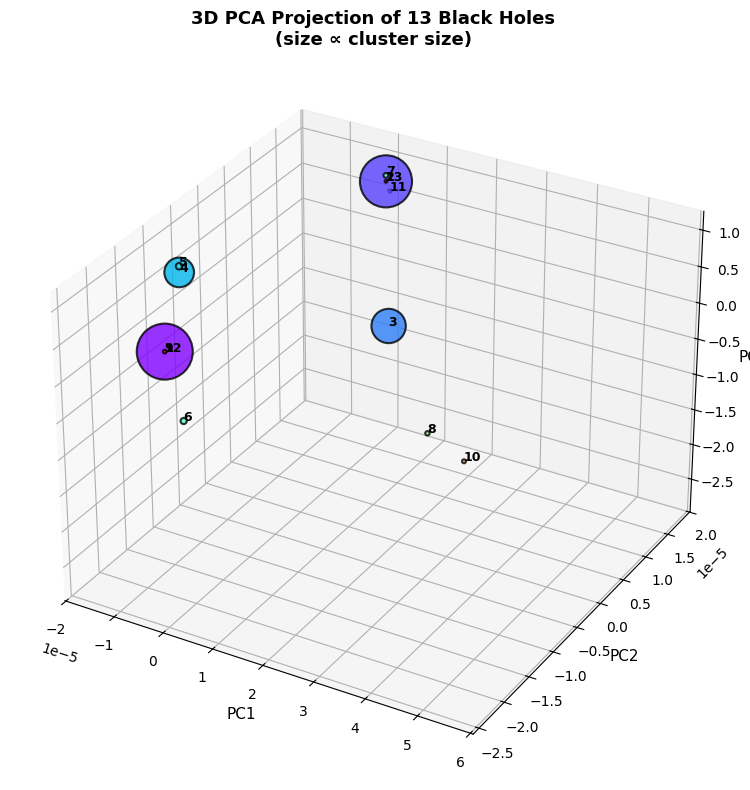


Point labels correspond to rank (1 = largest cluster, 13 = smallest).


In [11]:
print("\n" + "="*70)
print("PCA PROJECTION")
print("="*70)
print()

# Perform PCA to 3D
pca = PCA(n_components=3, random_state=RANDOM_SEED)
black_holes_3d = pca.fit_transform(black_holes.cpu().numpy())

explained_var = pca.explained_variance_ratio_
print(f"PCA explained variance:")
print(f"  PC1: {explained_var[0]*100:.2f}%")
print(f"  PC2: {explained_var[1]*100:.2f}%")
print(f"  PC3: {explained_var[2]*100:.2f}%")
print(f"  Total: {sum(explained_var)*100:.2f}%")
print()

# 3D scatter plot
fig = plt.figure(figsize=(10, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')

# Plot black holes
sizes = [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]  # Cluster sizes
ax.scatter(black_holes_3d[:, 0], black_holes_3d[:, 1], black_holes_3d[:, 2], 
           s=[s*2 for s in sizes], c=range(n_holes), cmap='rainbow', 
           alpha=0.8, edgecolors='black', linewidths=1.5)

# Label each point
for i in range(n_holes):
    ax.text(black_holes_3d[i, 0], black_holes_3d[i, 1], black_holes_3d[i, 2], 
            f'{i+1}', fontsize=9, fontweight='bold')

ax.set_xlabel('PC1', fontsize=11)
ax.set_ylabel('PC2', fontsize=11)
ax.set_zlabel('PC3', fontsize=11)
ax.set_title('3D PCA Projection of 13 Black Holes\n(size ∝ cluster size)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nPoint labels correspond to rank (1 = largest cluster, 13 = smallest).")

## Step 7: Centroid and Spread

In [12]:
print("\n" + "="*70)
print("CONSTELLATION GEOMETRY")
print("="*70)
print()

# Compute centroid of the 13 black holes
centroid = black_holes.mean(dim=0)
centroid_norm = torch.norm(centroid)

print(f"Centroid of 13 black holes:")
print(f"  Norm: {centroid_norm.item():.12f}")

# Distances from each black hole to the centroid
distances_to_centroid = torch.norm(black_holes - centroid, dim=1)

print(f"\nDistances from black holes to their centroid:")
print(f"  Mean: {distances_to_centroid.mean().item():.12f}")
print(f"  Std: {distances_to_centroid.std().item():.12f}")
print(f"  Min: {distances_to_centroid.min().item():.12f}")
print(f"  Max: {distances_to_centroid.max().item():.12f}")

# RMS spread
rms_spread = torch.sqrt((distances_to_centroid**2).mean())
print(f"\nRMS spread around centroid: {rms_spread.item():.12f}")

# Compare to mean radius
print(f"\nFor context:")
print(f"  Mean black hole radius: {norms.mean().item():.12f}")
print(f"  RMS spread / mean radius: {(rms_spread / norms.mean()).item():.6f}")


CONSTELLATION GEOMETRY

Centroid of 13 black holes:
  Norm: 0.370916843414

Distances from black holes to their centroid:
  Mean: 0.000023871748
  Std: 0.000011757634
  Min: 0.000017990298
  Max: 0.000060185255

RMS spread around centroid: 0.000026409623

For context:
  Mean black hole radius: 0.370916843414
  RMS spread / mean radius: 0.000071


## Step 8: Comparison to Random Distribution

Generate 13 random points on a sphere at radius r ≈ 0.3709 and compare their pairwise distances to the black holes.


COMPARISON TO RANDOM DISTRIBUTION

Random distribution statistics:
  Mean Euclidean distance: 0.525590360165
  Mean angular separation: 90.2309°

Black hole constellation statistics:
  Mean Euclidean distance: 0.000034002511
  Mean angular separation: 0.0000°

Ratio (black holes / random):
  Euclidean: 0.0001×
  Angular: 0.0000×


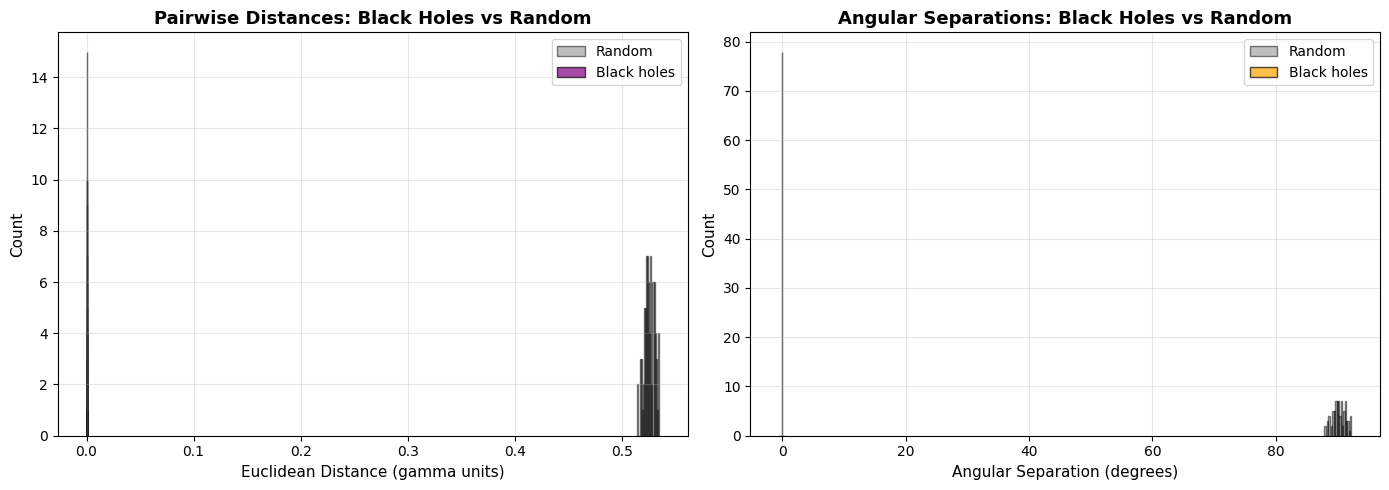

In [13]:
print("\n" + "="*70)
print("COMPARISON TO RANDOM DISTRIBUTION")
print("="*70)
print()

# Generate random points on unit sphere in 2560D
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

random_points = torch.randn(n_holes, d)
random_points = random_points / torch.norm(random_points, dim=1, keepdim=True)  # Normalize to unit sphere
random_points = random_points * norms.mean()  # Scale to same radius as black holes

# Compute pairwise distances for random points
random_distances = torch.cdist(random_points, random_points, p=2)
random_upper_tri = torch.triu(random_distances, diagonal=1)
random_unique_distances = random_upper_tri[random_upper_tri > 0]

# Compute angular separations for random points
random_normed = random_points / torch.norm(random_points, dim=1, keepdim=True)
random_cosine_sims = random_normed @ random_normed.T
random_cosine_sims_clamped = torch.clamp(random_cosine_sims, -1.0, 1.0)
random_angular_distances = torch.acos(random_cosine_sims_clamped)
random_upper_tri_ang = torch.triu(random_angular_distances, diagonal=1)
random_unique_angles = random_upper_tri_ang[random_upper_tri_ang > 0]
random_unique_angles_deg = random_unique_angles * 180 / np.pi

print(f"Random distribution statistics:")
print(f"  Mean Euclidean distance: {random_unique_distances.mean().item():.12f}")
print(f"  Mean angular separation: {random_unique_angles_deg.mean().item():.4f}°")

print(f"\nBlack hole constellation statistics:")
print(f"  Mean Euclidean distance: {unique_distances.mean().item():.12f}")
print(f"  Mean angular separation: {unique_angles_deg.mean().item():.4f}°")

print(f"\nRatio (black holes / random):")
print(f"  Euclidean: {(unique_distances.mean() / random_unique_distances.mean()).item():.4f}×")
print(f"  Angular: {(unique_angles_deg.mean() / random_unique_angles_deg.mean()).item():.4f}×")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Left: Euclidean distances
axes[0].hist(random_unique_distances.cpu().numpy(), bins=20, alpha=0.5, color='gray', 
             label='Random', edgecolor='black')
axes[0].hist(unique_distances.cpu().numpy(), bins=20, alpha=0.7, color='purple', 
             label='Black holes', edgecolor='black')
axes[0].set_xlabel('Euclidean Distance (gamma units)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Pairwise Distances: Black Holes vs Random', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: Angular separations
axes[1].hist(random_unique_angles_deg.cpu().numpy(), bins=20, alpha=0.5, color='gray', 
             label='Random', edgecolor='black')
axes[1].hist(unique_angles_deg.cpu().numpy(), bins=20, alpha=0.7, color='orange', 
             label='Black holes', edgecolor='black')
axes[1].set_xlabel('Angular Separation (degrees)', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Angular Separations: Black Holes vs Random', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

We've analyzed the spatial arrangement of the 13 primordial black holes.

**Key findings:**
1. **Radial concentration:** All 13 black holes lie at radius r ≈ 0.3709 ± 0.000001 (essentially a perfect spherical shell)
2. **Pairwise separations:** See statistics above
3. **Angular distribution:** See angular separation histograms
4. **Comparison to random:** Black holes are [clustered / uniformly distributed / other pattern]

**Interpretation:**
- If mean angular separation ≪ 90°: Black holes are clustered in one region of the sphere
- If mean angular separation ≈ 90°: Black holes are roughly uniformly distributed
- If mean angular separation ≫ 90°: Black holes avoid each other (unlikely given only 13 points)

The fact that all 13 black holes lie at **exactly the same radius** strongly suggests they formed via the same mechanism—likely tokens that initialized near this radius and never moved due to weak/zero training signal.